## 2) BA 지역의 배송지연 원인 분석

### (1) 시계열 분석

#### a. 요일별
 > 문제 발생 시점 및 단기 이슈 파악  
    -> 고객 이탈 방지를 위한 지연 급등 타이밍 확인

In [ ]:
ba = delivered[delivered['customer_state']=='BA'].copy()

In [ ]:
ba['weekday'] = ba['order_purchase_timestamp'].dt.day_name()

In [ ]:
ba.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,is_delayed,delay_days,days_approved_to_carrier,days_carrier_to_customer,weekday
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,...,4.0,Muito boa a loja,Muito bom o produto.,2018-08-08 00:00:00,2018-08-08 18:37:50,0,0.0,0.0,12.0,Tuesday
23,83018ec114eee8641c97e08f7b4e926f,7f8c8b9c2ae27bf3300f670c3d478be8,delivered,2017-10-26 15:54:26,2017-10-26 16:08:14,2017-10-26 21:46:53,2017-11-08 22:22:00,2017-11-23,634f09f6075fe9032e6c19609ffe995a,44024,...,4.0,NaN,NaN,2017-11-09 00:00:00,2017-11-10 01:06:29,0,0.0,0.0,13.0,Thursday


In [ ]:
# weekday 카테고리화
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ba['weekday'] = pd.Categorical(ba['weekday'], categories=weekday_order, ordered=True)
ba['weekday'].value_counts()

,count
weekday,
Thursday,648
Tuesday,626
Friday,621
Monday,580
Wednesday,572
Sunday,463
Saturday,440


In [ ]:
# 요일별 지연율 계산
weekday_delay = (ba.groupby('weekday')['is_delayed'].mean().reset_index().rename(columns={'is_delayed': 'delay_rate'}))
weekday_delay['delay_rate'] = weekday_delay['delay_rate'] * 100
weekday_delay

/tmp/ipython-input-39-1296674236.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weekday_delay = (ba.groupby('weekday')['is_delayed'].mean().reset_index().rename(columns={'is_delayed': 'delay_rate'}))


,weekday,delay_rate
0,Monday,15.000000
1,Tuesday,12.619808
2,Wednesday,13.986014
3,Thursday,12.962963
4,Friday,16.264090
5,Saturday,12.500000
6,Sunday,12.311015


In [ ]:
state_delay

,mean,count,delay_percent
customer_state,,,
AC,0.031915,94,3.191489
AL,0.244944,445,24.494382
AM,0.041176,170,4.117647
AP,0.048193,83,4.819277
BA,0.137468,3950,13.746835
CE,0.150266,1504,15.026596
DF,0.073151,2447,7.315080
ES,0.121225,2318,12.122519
GO,0.078497,2395,7.849687


In [ ]:
# 전체 평균 배송지연율
avg_delay_rate = state_delay['delay_percent'].mean()
avg_delay_rate

np.float64(10.315151418906725)

In [ ]:
# BA 지역 평균 배송지연율
ba_delay_rate = state_delay.loc['BA', 'delay_percent']
ba_delay_rate

np.float64(13.746835443037975)

##### 시각화

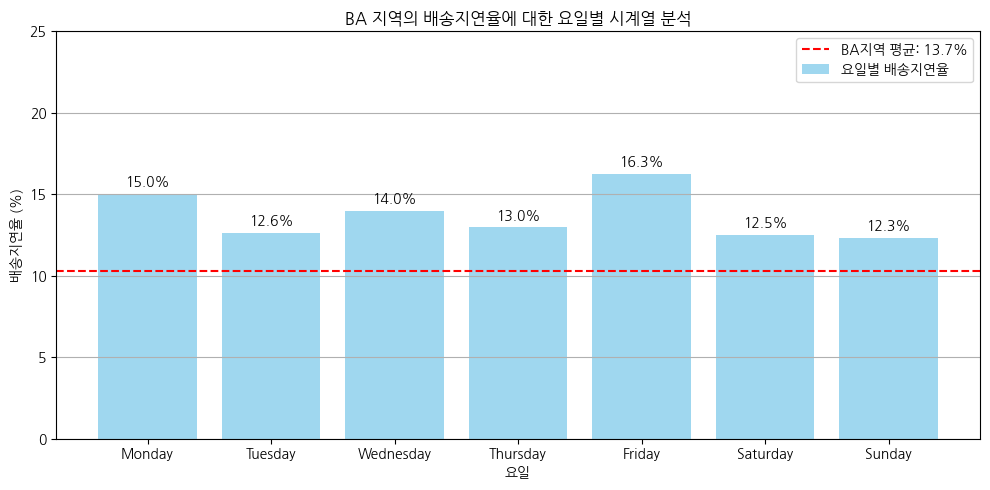

In [ ]:
# 시각화
plt.figure(figsize=(10, 5))
bars = plt.bar(weekday_delay['weekday'], weekday_delay['delay_rate'], alpha=0.8, color='skyblue', label='요일별 배송지연율')

for i in range(len(weekday_delay)):
    x = weekday_delay['weekday'][i]
    y = weekday_delay['delay_rate'][i]
    plt.text(x, y + 0.3, f'{y:.1f}%', ha='center', va='bottom', fontsize=10)

plt.axhline(avg_delay_rate, color='red', linestyle='--', linewidth=1.5, label=f'BA지역 평균: {ba_delay_rate:.1f}%')
plt.title('BA 지역의 배송지연율에 대한 요일별 시계열 분석')
plt.xlabel('요일')
plt.ylabel('배송지연율 (%)')
plt.ylim([0, 25])
plt.grid(axis='y')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show();

[요일별 분석]
> 금요일에 배송지연율 가장 높음(16.3%)
- 원인 : 주말 전 주문량 증가로 인한 물류 적체로 추정
- 전략
    - 목요일 발송 유도 프로모션 : 금요일 주문 유도 대신 목요일 주문 시 쿠폰 제공 등
    - 금요일 물류 인력 증원 : 아르바이트 인력 투입, 탄력적 배차 운영
    - 프리미엄 상품 및 고객에 대해 금요일 배송 우선처리 정책

#### b. 일별
- 주문 건수 자체가 낮아 배송 지연율이 높아 보이는 경우 확인됨  
    -> 주문건수가 5개 이상인 날로 필터링하여 분석

In [ ]:
# 일별 지연율 계산
daily_delay = (ba.groupby(ba['order_purchase_timestamp'].dt.date)['is_delayed'].agg(['count','mean']).reset_index().rename(columns={'order_purchase_timestamp': 'date', 'mean': 'delay_rate'}))
daily_delay['delay_rate'] = daily_delay['delay_rate']*100
daily_delay

,date,count,delay_rate
0,2016-10-04,1,0.0
1,2016-10-08,1,0.0
2,2016-10-10,1,0.0
3,2017-01-05,1,0.0
4,2017-01-15,1,0.0
...,...,...,...
566,2018-08-17,7,0.0
567,2018-08-18,4,0.0
568,2018-08-19,1,0.0
569,2018-08-20,6,0.0


In [ ]:
daily_delay.sort_values('delay_rate', ascending=False).head(10)

,date,count,delay_rate
88,2017-04-19,1,100.000000
73,2017-04-03,2,100.000000
245,2017-09-29,1,100.000000
132,2017-06-04,1,100.000000
386,2018-02-18,7,85.714286
394,2018-02-26,5,80.000000
226,2017-09-10,13,76.923077
424,2018-03-28,7,71.428571
318,2017-12-12,6,66.666667
448,2018-04-21,3,66.666667


In [ ]:
# 주문 수가 5건 이상인 날짜만 필터링
daily_delay_filtered = daily_delay[daily_delay['count'] >= 5]

In [ ]:
daily_delay_filtered.sort_values('delay_rate', ascending=False).head(10)

,date,count,delay_rate
386,2018-02-18,7,85.714286
394,2018-02-26,5,80.000000
226,2017-09-10,13,76.923077
424,2018-03-28,7,71.428571
222,2017-09-06,12,66.666667
318,2017-12-12,6,66.666667
425,2018-03-29,8,62.500000
399,2018-03-03,5,60.000000
509,2018-06-21,10,60.000000
405,2018-03-09,12,58.333333


##### 시각화

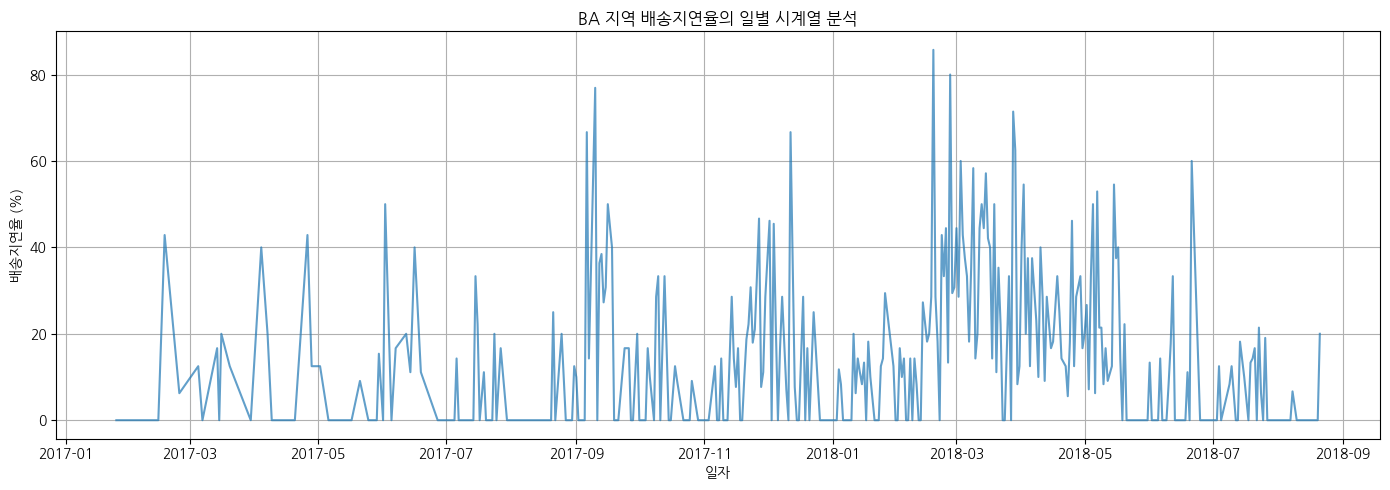

In [ ]:
# 일별 시계열 분석 시각화
plt.figure(figsize=(14, 5))
plt.plot(daily_delay_filtered['date'], daily_delay_filtered['delay_rate'], alpha=0.7)
plt.title('BA 지역 배송지연율의 일별 시계열 분석')
plt.xlabel('일자')
plt.ylabel('배송지연율 (%)')
plt.grid(True)
plt.tight_layout()
plt.show();

#### c. 주별


In [ ]:
ba['year_week'] = ba['order_purchase_timestamp'].dt.strftime('%Y-%U')

In [ ]:
# 주별 평균 지연율 계산
weekly_delay = (ba.groupby('year_week')['is_delayed'].mean().reset_index().rename(columns={'is_delayed': 'delay_rate'}))
weekly_delay['delay_rate'] *= 100
weekly_delay.sort_values('delay_rate', ascending=False)

,year_week,delay_rate
64,2018-10,43.421053
37,2017-37,38.666667
63,2018-09,35.135135
62,2018-08,33.333333
61,2018-07,32.258065
...,...,...
33,2017-33,0.000000
31,2017-31,0.000000
79,2018-25,0.000000
84,2018-30,0.000000


In [ ]:
weekly_delay['week_start'] = pd.to_datetime(weekly_delay['year_week'] + '-1', format='%Y-%U-%w')

##### 시각화

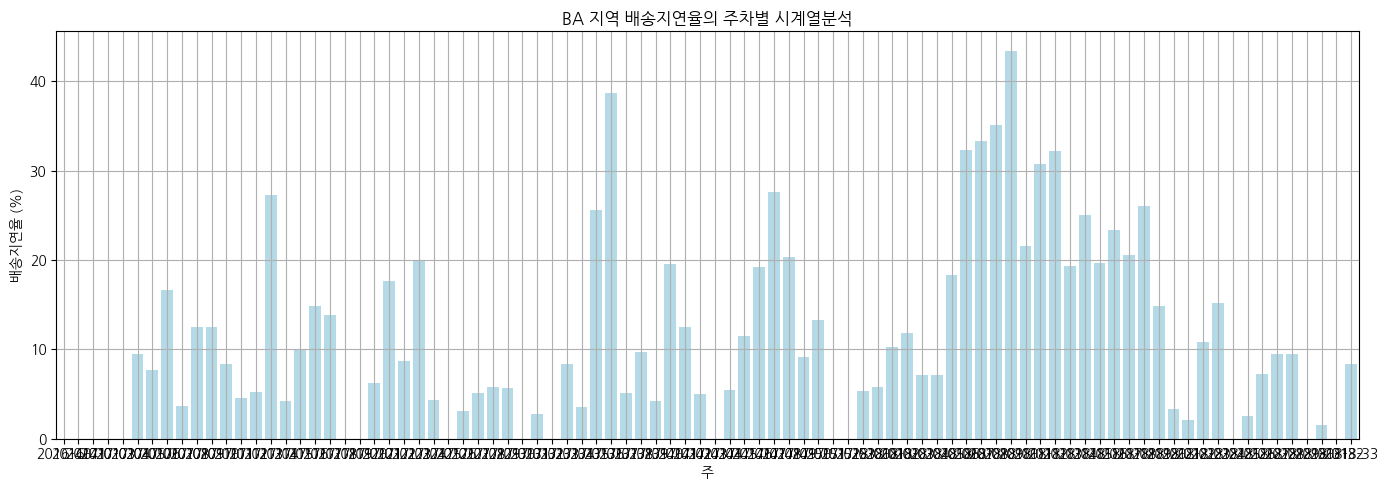

In [ ]:
# 시각화
plt.figure(figsize=(14, 5))
sns.barplot(data= weekly_delay, x='year_week', y='delay_rate', alpha=0.7, color='skyblue')
plt.title('BA 지역 배송지연율의 주차별 시계열분석')
plt.xlabel('주')
plt.ylabel('배송지연율 (%)')
plt.grid(True)
plt.tight_layout()
plt.show();

#### d. 연도-월별

In [ ]:
# 월 단위로 변환
ba['year_month'] = ba['order_purchase_timestamp'].dt.to_period('M')

# 월별 평균 지연율 계산
year_monthly_delay = (ba.groupby('year_month')['is_delayed'].mean().reset_index().rename(columns={'is_delayed': 'delay_rate'}))

year_monthly_delay['delay_rate'] *= 100
year_monthly_delay.sort_values('delay_rate', ascending=False)

,year_month,delay_rate
15,2018-03,33.898305
16,2018-04,23.790323
9,2017-09,21.904762
14,2018-02,20.075758
17,2018-05,18.918919
11,2017-11,15.434084
4,2017-04,15.306122
12,2017-12,14.479638
6,2017-06,13.768116
10,2017-10,9.743590


In [ ]:
year_monthly_delay.shape

(21, 2)

In [ ]:
year_monthly_delay['year_month'] = year_monthly_delay['year_month'].dt.to_timestamp()

In [ ]:
year_monthly_delay['year_month_str'] = year_monthly_delay['year_month'].dt.strftime('%Y-%m')

In [ ]:
year_monthly_delay.sort_values('delay_rate', ascending=False)

,year_month,delay_rate,year_month_str
15,2018-03-01,33.898305,2018-03
16,2018-04-01,23.790323,2018-04
9,2017-09-01,21.904762,2017-09
14,2018-02-01,20.075758,2018-02
17,2018-05-01,18.918919,2018-05
11,2017-11-01,15.434084,2017-11
4,2017-04-01,15.306122,2017-04
12,2017-12-01,14.479638,2017-12
6,2017-06-01,13.768116,2017-06
10,2017-10-01,9.743590,2017-10


##### 시각화

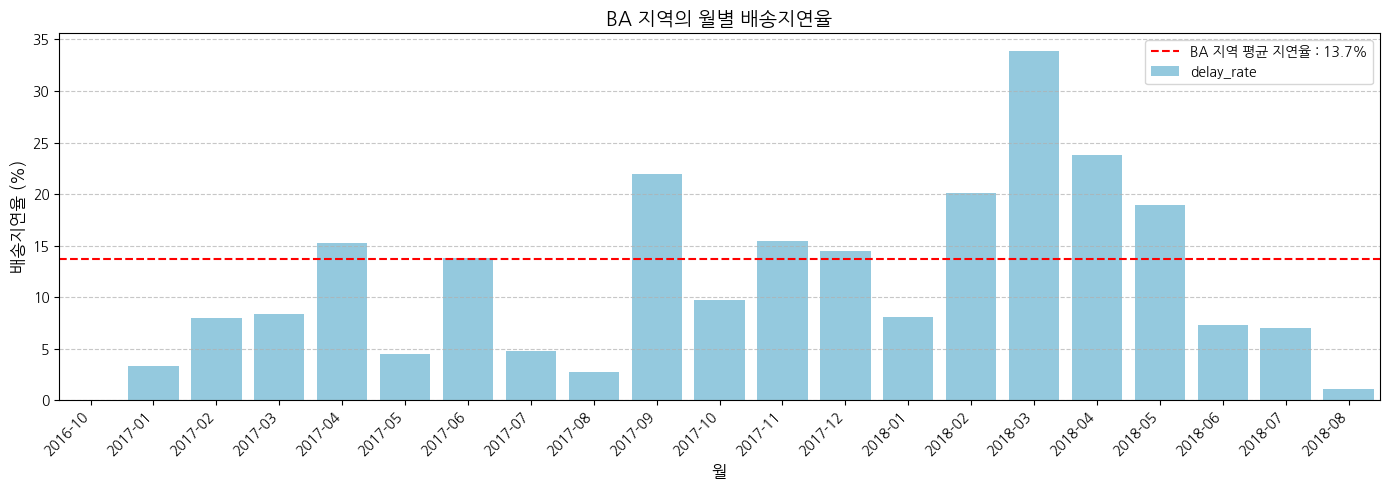

In [ ]:
# 시각화
plt.figure(figsize=(14, 5))
bar = sns.barplot(data=year_monthly_delay, x='year_month_str', y='delay_rate', color='skyblue', label='delay_rate')
plt.axhline(ba_delay_rate, color='red', linestyle='--', linewidth=1.5, label=f'BA 지역 평균 지연율 : {ba_delay_rate:.1f}%')
plt.title('BA 지역의 월별 배송지연율', fontsize=14)
plt.xlabel('월', fontsize=12)
plt.ylabel('배송지연율 (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show();

> 2018년 2-4월 배송 지연율 급증  
- 원인   
    - 2~4월 브라질 여름 휴가, 2월 카니발 축제 영향으로 추정  
    - 2018년 트럭 운전사 파업, 세관 통관 지연, 항만 병목이 집중된 시점으로 이에 따른 결과로 추정

> -> 반복 패턴 확인 어려워 일시적 이벤트로 생각됨

#### e. 월별

In [ ]:
# 월 단위로 변환
ba['month'] = ba['order_purchase_timestamp'].dt.month

In [ ]:
# 월별 평균 지연율 계산
month_delay = ( ba.groupby('month')['is_delayed']
    .mean()
    .reset_index()
    .rename(columns={'is_delayed': 'delay_rate'}))
month_delay['delay_rate'] *= 100
month_delay.sort_values('delay_rate', ascending=False)

,month,delay_rate
2,3,27.047146
8,9,21.904762
3,4,21.387283
1,2,17.404130
10,11,15.434084
11,12,14.479638
4,5,13.968958
5,6,9.729730
9,10,9.595960
0,1,7.615894


##### 시각화 ★

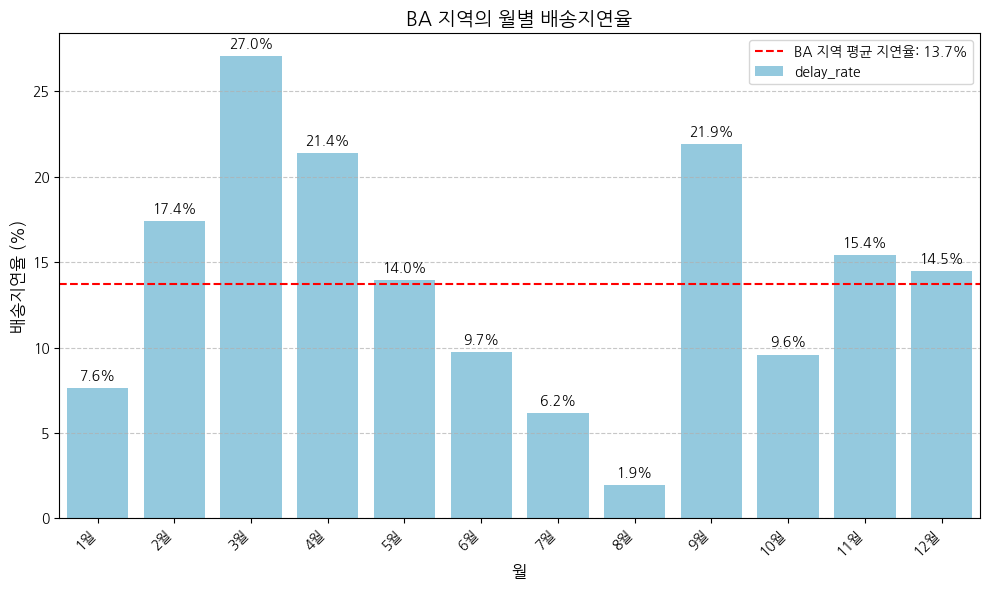

In [ ]:
# 시각화
plt.figure(figsize=(10, 6))

bar = sns.barplot(data=month_delay, x='month', y='delay_rate', color='skyblue', label='delay_rate')

for i in range(len(month_delay)):
    x = i
    y = month_delay['delay_rate'][i]
    plt.text(x, y + 0.3, f'{y:.1f}%', ha='center', va='bottom', fontsize=10)

plt.axhline(ba_delay_rate, color='red', linestyle='--', linewidth=1.5, label=f'BA 지역 평균 지연율: {ba_delay_rate:.1f}%')

plt.title('BA 지역의 월별 배송지연율', fontsize=14)
plt.xlabel('월', fontsize=12)
plt.ylabel('배송지연율 (%)', fontsize=12)

plt.xticks(ticks=range(len(month_delay)), labels=[f'{m}월' for m in month_delay['month']], rotation=45, ha='right')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show();

>  3월에 배송지연율 가장 높으며 2-4월동안 높은 추이
- [원인]  : 브라질 휴가 및 카니발 12월-2월, 이후 3월부터 업무 재개 및 주문 급증으로 추정
- [제안]
        - 2월 중 사전 출고 유도 캠페인 추진
        - 셀러들에게 휴가철 1~2주 전까지 미리 출고하면 혜택 제공(수수료 할인, 배너 노출 등)
        - 휴가철 프리미엄 회원에 대해 정시배송 보장
        - 배송지연 보험 프로그램 or 리워드(적립금, 쿠폰 등) 제공

### (2) 배송단계별 분석

#### a. 단계별 리드타임

In [ ]:
# 승인 → 운송사 전달까지 소요일수
ba['days_approved_to_carrier'] = (ba['order_delivered_carrier_date'] - ba['order_approved_at']).dt.days

# 운송사 전달 → 고객 수령까지 소요일수
ba['days_carrier_to_customer'] = (ba['order_delivered_customer_date'] - ba['order_delivered_carrier_date']).dt.days

# 배송기한(shipping_limit) 초과 일수
ba['days_shipping_limit_over'] = (ba['order_delivered_carrier_date'] - ba['shipping_limit_date']).dt.days
ba['days_shipping_limit_over'] = ba['days_shipping_limit_over'].apply(lambda x: x if x > 0 else 0)

In [ ]:
avg_step1 = ba['days_approved_to_carrier'].mean()
avg_step2 = ba['days_carrier_to_customer'].mean()
avg_step3 = ba['days_shipping_limit_over'].mean()

delivery_timing_summary = pd.DataFrame({
    'step': ['승인→운송사', '운송사→고객', '배송기한 초과일수'],
    'average_days': [avg_step1, avg_step2, avg_step3]})

In [ ]:
delivery_timing_summary

,step,average_days
0,승인→운송사,2.381519
1,운송사→고객,15.365570
2,배송기한 초과일수,0.217722


##### 시각화

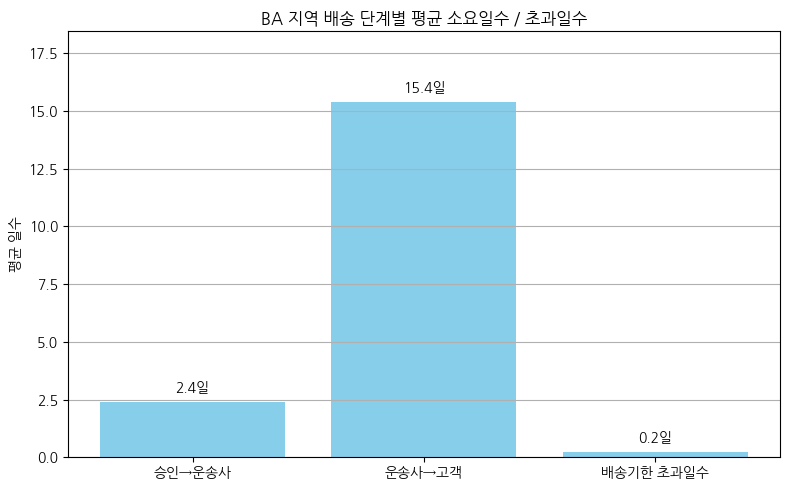

In [ ]:
plt.figure(figsize=(8, 5))
plt.bar(delivery_timing_summary['step'], delivery_timing_summary['average_days'], color='skyblue')

for i in range(len(delivery_timing_summary)):
    x = delivery_timing_summary['step'][i]
    y = delivery_timing_summary['average_days'][i]
    plt.text(x, y + 0.3, f'{y:.1f}일', ha='center', va='bottom', fontsize=10)


plt.title('BA 지역 배송 단계별 평균 소요일수 / 초과일수')
plt.ylabel('평균 일수')
plt.ylim(0, delivery_timing_summary['average_days'].max() * 1.2)
plt.grid(axis='y')
plt.tight_layout()
plt.show();

#### b. 전체 평균 리드타임 비교

In [ ]:
delivered['days_approved_to_carrier'] = (delivered['order_delivered_carrier_date'] - delivered['order_approved_at']).dt.days
delivered['days_carrier_to_customer'] = (delivered['order_delivered_customer_date'] - delivered['order_delivered_carrier_date']).dt.days
delivered['days_shipping_limit_over'] = (delivered['order_delivered_carrier_date'] - delivered['shipping_limit_date']).dt.days
delivered['days_shipping_limit_over'] = delivered['days_shipping_limit_over'].apply(lambda x: x if x > 0 else 0)

In [ ]:
# 전체 평균
total_means = {'승인→운송사': delivered['days_approved_to_carrier'].mean(),
                       '운송사→고객': delivered['days_carrier_to_customer'].mean(),
                        '배송기한 초과일수': delivered['days_shipping_limit_over'].mean()}
total_means

{'승인→운송사': np.float64(2.3477779890411905),
 '운송사→고객': np.float64(8.746824066232262),
 '배송기한 초과일수': np.float64(0.24477415898308894)}

In [ ]:
ba_means = {'승인→운송사': ba['days_approved_to_carrier'].mean(),
                        '운송사→고객': ba['days_carrier_to_customer'].mean(),
                        '배송기한 초과일수': ba['days_shipping_limit_over'].mean()}

In [ ]:
comparison_df = pd.DataFrame({
    '단계': total_means.keys(),
    '전체 평균': total_means.values(),
    'BA 평균': ba_means.values()})
comparison_df

,단계,전체 평균,BA 평균
0,승인→운송사,2.347778,2.381519
1,운송사→고객,8.746824,15.365570
2,배송기한 초과일수,0.244774,0.217722


In [ ]:
comparison_df['차이(BA - 전체)'] = comparison_df['BA 평균'] - comparison_df['전체 평균']
comparison_df['지연 많은가?'] = comparison_df['차이(BA - 전체)'].apply(lambda x: 'Yes' if x > 0 else 'No')

##### 시각화

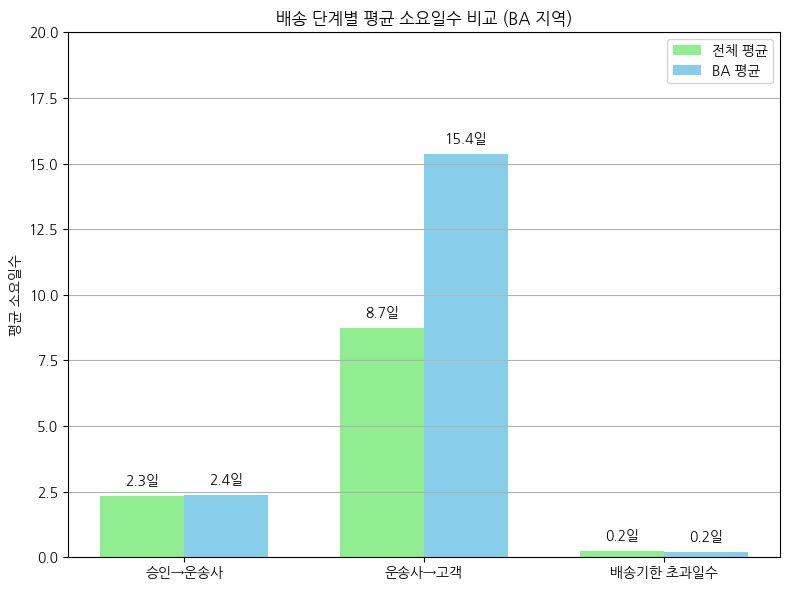

In [ ]:
# 시각화
x = comparison_df['단계']
total = comparison_df['전체 평균']
ba_avg = comparison_df['BA 평균']

plt.figure(figsize=(8, 6))
bar_width = 0.35
index = range(len(x))

bars1 = plt.bar(index, total, bar_width, label='전체 평균' , color='lightgreen')
bars2 = plt.bar([i + bar_width for i in index], ba_avg, bar_width, label='BA 평균', color='skyblue')

plt.xticks([i + bar_width / 2 for i in index], x)
plt.ylabel('평균 소요일수')
plt.title('배송 단계별 평균 소요일수 비교 (BA 지역)')
plt.ylim([0,20])
plt.legend()
plt.grid(axis='y')


for i in range(len(index)):
    plt.text(index[i], total[i] + 0.3, f'{total[i]:.1f}일', ha='center', va='bottom', fontsize=10)
    plt.text(index[i] + bar_width, ba_avg[i] + 0.3, f'{ba_avg[i]:.1f}일', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show();

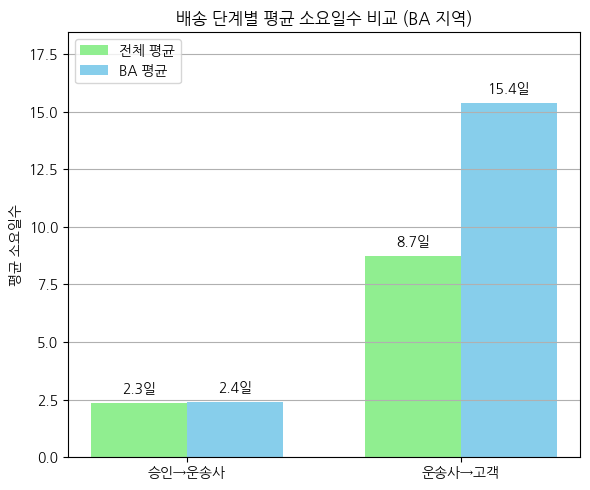

In [ ]:
# 배송기한 초과일수 제외하고 비교
# '승인→운송사'와 '운송사→고객' 단계만 필터링
filtered_df = comparison_df[comparison_df['단계'].isin(['승인→운송사', '운송사→고객'])]

# 데이터 준비
x = filtered_df['단계']
total = filtered_df['전체 평균']
ba_avg = filtered_df['BA 평균']

plt.figure(figsize=(6, 5))
bar_width = 0.35
index = range(len(x))

# 막대 그래프
bars1 = plt.bar(index, total, bar_width, label='전체 평균', color='lightgreen')
bars2 = plt.bar([i + bar_width for i in index], ba_avg, bar_width, label='BA 평균', color='skyblue')

# x축 설정
plt.xticks([i + bar_width / 2 for i in index], x)
plt.ylabel('평균 소요일수')
plt.title('배송 단계별 평균 소요일수 비교 (BA 지역)')
plt.ylim([0, max(total.max(), ba_avg.max()) * 1.2])
plt.legend()
plt.grid(axis='y')

# 수치 라벨 추가
for i in range(len(index)):
    plt.text(index[i], total.iloc[i] + 0.3, f'{total.iloc[i]:.1f}일', ha='center', va='bottom', fontsize=10)
    plt.text(index[i] + bar_width, ba_avg.iloc[i] + 0.3, f'{ba_avg.iloc[i]:.1f}일', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show();

> 운송사 -> 고객 단계 소요일수가 15.4일로 전체 평균(8.7일)보다 약 6.7일 더 오래 걸림
- [원인]
    - BA 지역은 면적이 넓고(브라질에서 5번째, 프랑스 면적보다 조금 넓음) 도심권 대비 농촌/외각 지역 비중이 높음 -> 배송 경로가 길어지고 인프라 부족으로 인해 배송 지연 발생하는 것으로 추정
- [전략]
    - 배송 인프라 보완(거점 물류센터 확보)
    - 정기 배송 모니터링 리포트 제공 : 배송지연 패턴을 실시간으로 모니터링하고 파트너에게 피드백
    - 1대의 트럭이 복수 셀러 주문을 함께 픽업 & 배송하는 공동 시스템 도입